# Redes neuronales para estimar la calidad del concreto

Vamos a crear un modelo de redes neuronales para predecir la fuerza de una preparación de concreto, dada su composición. El diccionario de datos es el siguiente:

- cement (componente 1): cemento, kg en un metro cúbico de mezcla
- slag (componente 2): escorias de horno, kg en un metro cúbico de mezcla
- ash (componente 3): ceniza, kg en un metro cúbico de mezcla
- water (componente 4): agua,  kg en un metro cúbico de mezcla
- superplastic (componente 5): superplastificante, kg en un metro cúbico de mezcla
- coarseagg (componente 6): agregado grueso, kg en un metro cúbico de mezcla
- fineagg (componente 7): agregado fino, kg en un metro cúbico de mezcla
- age: días desde que se creó la mezcla
- strength: fuerza compresiva del concreto, en MPa (**variable objetivo**)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd #tratamiento de datos
import matplotlib.pyplot as plt #gráficos
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split #metodo de particionamiento de datasets para evaluación
from sklearn.model_selection import GridSearchCV #permite buscar la mejor configuración de parámetros con C-V
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

## Entendimiento de los datos

Cargamos los datos para entenderlos

In [3]:
df = pd.read_csv('07-04-Concrete.csv', sep=',', na_values=".")
print(df.shape)
df.head(5)

(1030, 9)


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


Tenemos entonces que el baseline de predicción de la fuerza del concreto es:

In [4]:
np.mean(df.strength)

35.817961165048544

In [5]:
df.describe(include="all").T

,count,mean,std,min,25%,50%,75%,max
cement,1030.0,281.167864,104.506364,102.00,192.375,272.900,350.000,540.0
slag,1030.0,73.895825,86.279342,0.00,0.000,22.000,142.950,359.4
ash,1030.0,54.188350,63.997004,0.00,0.000,0.000,118.300,200.1
water,1030.0,181.567282,21.354219,121.80,164.900,185.000,192.000,247.0
superplastic,1030.0,6.204660,5.973841,0.00,0.000,6.400,10.200,32.2
coarseagg,1030.0,972.918932,77.753954,801.00,932.000,968.000,1029.400,1145.0
fineagg,1030.0,773.580485,80.175980,594.00,730.950,779.500,824.000,992.6
age,1030.0,45.662136,63.169912,1.00,7.000,28.000,56.000,365.0
strength,1030.0,35.817961,16.705742,2.33,23.710,34.445,46.135,82.6


Vemos que no hay variables con valores faltantes y que todas las variables son numéricas, aunque con diferencias de escalas. Como vamos a usar redes neuronales, no es necesario normalizar.

Preparamos los datos en entrenamiento y de evaluación:

In [6]:
X = df.loc[:,['cement', 'slag', 'ash', 'water', 'superplastic', 'coarseagg',
       'fineagg', 'age']]
y = df.loc[:,['strength']]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

El baseline nos daría las siguientes métricas de evaluación:

In [8]:
y_pred = np.full(X_test.shape[0], np.mean(df.strength))
print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)), ", MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

RMSE: 15.349755546218644 , MAE: 12.272369985700307 , R2: -0.00013373113397885383 



## Modelamiento

In [9]:
mlp = MLPRegressor(hidden_layer_sizes=(30,30,30))
mlp.fit(X_train,y_train)

MLPRegressor(hidden_layer_sizes=(30, 30, 30))

In [10]:
y_pred = mlp.predict(X_test)
print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)), ", MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

RMSE: 6.286971798244223 , MAE: 4.669808513692062 , R2: 0.8322207795157498 



<font color = "red">Encuentre la mejor red neuronal utilizando **GridSearchCV**, buscando la mejor combinación de los parámetros siguientes:</font>
* <font color = "red">**activation**: función de activación, a escoger entre 'logistic', 'tanh', 'relu' (valor por defecto)</font>
* <font color = "red">**max_iter**: máximo número de épocas de entrenamiento (por defecto, 200). Puede que no se necesiten todas las especificadas si se llega a convergencia).</font>
* <font color = "red">**hidden_layer_sizes**: topología de la red, vector indicando el número de neuronas por capa. Por defecto solo se tiene un capa escondidad con 100 neuronas: (100).</font>
* <font color = "red">**learning_rate_init**: tasa de aprendizaje inicial (por defecto es constante aunque se puede modificar esta tasa a medida que se va avanzando en el número de épocas). Por defecto, el valor es 0.001. </font>

In [11]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05]

In [12]:
mlp = MLPRegressor(hidden_layer_sizes=(30,30,30))

### activation

In [13]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec
              }
scoring = {'mae':'neg_mean_absolute_error', 'r2':'r2'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='mae', n_jobs=-1)
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un MAE de {1:.2f}% y un R2 de {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_r2'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu'}, que permiten obtener un MAE de -641.94% y un R2 de 75.38
Tiempo total: 0.08 minutos


In [14]:
df = pd.DataFrame([(activation, mae*100, r2*100) for (activation, mae, r2) in 
                   zip(activation_vec, 
                       grid.cv_results_['mean_test_mae'], 
                       grid.cv_results_['mean_test_r2'],
                      )
                   ], columns = ('activation', 'MAE', 'R2'))

In [15]:
df

,activation,MAE,R2
0,logistic,-1929.657165,-101.890165
1,relu,-641.940318,75.377635
2,tanh,-1526.240729,-28.862572


In [16]:
y_pred = grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

MAE: 5.622085122001836 , R2: 0.7876128486524439 



### max_iter

In [17]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'max_iter':max_iter_vec
              }

scoring = {'mae':'neg_mean_absolute_error', 'r2':'r2'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='mae', n_jobs=-1)
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un MAE de {1:.2f}% y un R2 de {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_r2'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'max_iter': 400}, que permiten obtener un MAE de -593.32% y un R2 de 79.81
Tiempo total: 0.07 minutos


In [18]:
df = pd.DataFrame([(max_iter, mae*100, r2*100) for (max_iter, mae, r2) in 
                   zip(max_iter_vec, 
                       grid.cv_results_['mean_test_mae'], 
                       grid.cv_results_['mean_test_r2'],
                      )
                   ], columns = ('max_iter', 'MAE', 'R2'))

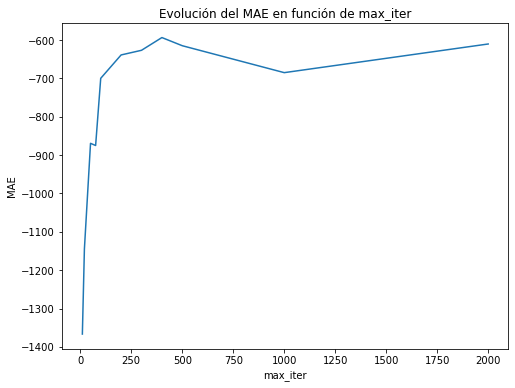

In [19]:
plt.figure(figsize=(8,6))
ax = plt.gca() # get current axis
plt.plot(df.max_iter, df.MAE)
plt.xlabel('max_iter')
plt.ylabel('MAE')
plt.title('Evolución del MAE en función de max_iter')
plt.show()

In [20]:
y_pred = grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

MAE: 5.921547100630718 , R2: 0.7790814717172585 



### hidden_layer_sizes

In [21]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'hidden_layer_sizes':hidden_layer_sizes_vec
              }

scoring = {'mae':'neg_mean_absolute_error', 'r2':'r2'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='mae', n_jobs=-1)
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un MAE de {1:.2f}% y un R2 de {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_r2'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'hidden_layer_sizes': (20, 20)}, que permiten obtener un MAE de -648.82% y un R2 de 74.96
Tiempo total: 0.04 minutos


In [22]:
df = pd.DataFrame([(hidden_layer_sizes, mae*100, r2*100) for (hidden_layer_sizes, mae, r2) in 
                   zip(hidden_layer_sizes_vec, 
                       grid.cv_results_['mean_test_mae'], 
                       grid.cv_results_['mean_test_r2'],
                      )
                   ], columns = ('hidden_layer_sizes', 'MAE', 'R2'))

In [23]:
df

,hidden_layer_sizes,MAE,R2
0,"(10,)",-1346.696473,-13.861464
1,"(20,)",-1289.665964,-2.868614
2,"(30,)",-772.597232,64.104116
3,"(10, 10)",-1043.554226,38.389174
4,"(20, 20)",-648.822045,74.961994
5,"(30, 30)",-680.621842,73.382298
6,"(20, 10)",-877.426060,57.365971
7,"(30, 20, 10)",-675.170846,74.108081


In [24]:
y_pred = grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

MAE: 7.239727186493469 , R2: 0.6167857342616251 



### learning_rate_init

In [25]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'learning_rate_init':learning_rate_init_vec
              }
scoring = {'mae':'neg_mean_absolute_error', 'r2':'r2'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='mae', n_jobs=-1)
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un MAE de {1:.2f}% y un R2 de {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_r2'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'learning_rate_init': 0.009}, que permiten obtener un MAE de -585.91% y un R2 de 79.80
Tiempo total: 0.06 minutos


In [26]:
df = pd.DataFrame([(learning_rate_init, mae*100, r2*100) for (learning_rate_init, mae, r2) in 
                   zip(learning_rate_init_vec, 
                       grid.cv_results_['mean_test_mae'], 
                       grid.cv_results_['mean_test_r2'],
                      )
                   ], columns = ('learning_rate_init', 'MAE', 'R2'))

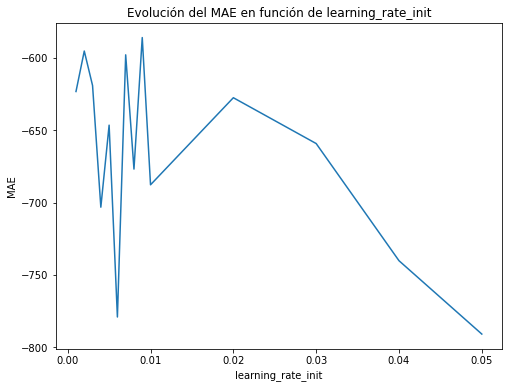

In [27]:
plt.figure(figsize=(8,6))
ax = plt.gca() # get current axis
plt.plot(df.learning_rate_init, df.MAE)
plt.xlabel('learning_rate_init')
plt.ylabel('MAE')
plt.title('Evolución del MAE en función de learning_rate_init')
plt.show()

In [28]:
y_pred = grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

MAE: 6.3231285788716765 , R2: 0.7210657186457596 



### mejor combinación

In [29]:
activation_vec = ['logistic', 'relu', 'tanh']
max_iter_vec = [10, 20, 50, 75, 100, 200, 300, 400, 500, 1000, 2000]
hidden_layer_sizes_vec = [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30), (20, 10), 
                          (10, 10, 10), (20, 20, 20), (30, 30, 30), (30, 20, 10)]
learning_rate_init_vec = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02]

In [30]:
import time
start = time.time() # Devuelve el tiempo actual en segundos desde el 1o de enero de 1970 (punto de referencia)

np.random.seed(1234)
parametros = {'activation': activation_vec,
              'max_iter':max_iter_vec,
              'hidden_layer_sizes': hidden_layer_sizes_vec,
              'learning_rate_init': learning_rate_init_vec
              }

scoring = {'mae':'neg_mean_absolute_error', 'r2':'r2'}
grid = GridSearchCV(mlp, param_grid=parametros, cv=5, scoring=scoring, refit='mae', n_jobs=-1)

### <font color="red"><b>DESDE AQUÍ: NO EJECUTAR DE NUEVO (+20 minutos)</b></font>

In [31]:
grid.fit(X_train, y_train)

print("Los parámetros del mejor modelo fueron {0}, que permiten obtener un MAE de {1:.2f}% y un R2 de {2:.2f}".format(
    grid.best_params_, grid.best_score_*100, grid.cv_results_['mean_test_r2'][grid.best_index_]*100))
end = time.time() # Tiempo después de finalizar el entrenamiento del modelo
print("Tiempo total: {0:.2f} minutos".format((end-start)/60))

Los parámetros del mejor modelo fueron {'activation': 'relu', 'hidden_layer_sizes': (20, 20, 20), 'learning_rate_init': 0.005, 'max_iter': 2000}, que permiten obtener un MAE de -548.66% y un R2 de 81.75
Tiempo total: 17.40 minutos


### <font color="red"><b>HASTA ACÁ (+15 minutos)</b></font>

In [32]:
df = pd.DataFrame([(mae*100, r2*100) for (mae, r2) in 
                   zip( 
                       grid.cv_results_['mean_test_mae'], 
                       grid.cv_results_['mean_test_r2'],
                      )
                   ], columns = ('MAE', 'R2'))

In [33]:
df.iloc[np.argsort(-df.MAE),]

,MAE,R2
2353,-548.660172,81.746790
2436,-561.106581,80.053438
2496,-570.639961,80.440878
2559,-572.297013,80.806378
2611,-582.349997,80.290895
...,...,...
1694,-4722.326729,-1704.177660
1353,-6304.795533,-2980.326069
1452,-6417.719122,-2774.597033
1332,-6460.620017,-3530.004251


In [34]:
grid.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_activation', 'param_hidden_layer_sizes', 'param_learning_rate_init', 'param_max_iter', 'params', 'split0_test_mae', 'split1_test_mae', 'split2_test_mae', 'split3_test_mae', 'split4_test_mae', 'mean_test_mae', 'std_test_mae', 'rank_test_mae', 'split0_test_r2', 'split1_test_r2', 'split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'mean_test_r2', 'std_test_r2', 'rank_test_r2'])

In [35]:
y_pred = grid.best_estimator_.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred), ", R2:", r2_score(y_test, y_pred), "\n")

MAE: 5.413362474322595 , R2: 0.8076188163828342 



In [36]:
df = pd.DataFrame([(act, hidden_layers, lr, max_iter, acc*100, kappa*100) for (act, hidden_layers, lr, max_iter, acc, kappa) in 
                   zip(
                       grid.cv_results_['param_activation'], 
                       grid.cv_results_['param_hidden_layer_sizes'], 
                       grid.cv_results_['param_learning_rate_init'], 
                       grid.cv_results_['param_max_iter'], 
                       grid.cv_results_['mean_test_mae'], 
                       grid.cv_results_['mean_test_r2'],
                      )
                   ], columns = ('Activation', 'HiddenLayers', 'LearningRate', 'MaxIter', 'MAE', 'R2'))

In [37]:
df.iloc[np.argsort(-df.MAE),].head(20)

,Activation,HiddenLayers,LearningRate,MaxIter,MAE,R2
2353,relu,"(20, 20, 20)",0.005,2000,-548.660172,81.746790
2436,relu,"(30, 30, 30)",0.002,200,-561.106581,80.053438
2496,relu,"(30, 30, 30)",0.007,2000,-570.639961,80.440878
2559,relu,"(30, 20, 10)",0.002,400,-572.297013,80.806378
2611,relu,"(30, 20, 10)",0.007,100,-582.349997,80.290895
2548,relu,"(30, 20, 10)",0.001,400,-583.004996,80.037026
1879,relu,"(20, 20)",0.006,1000,-583.234305,80.064223
2450,relu,"(30, 30, 30)",0.003,500,-583.709768,80.649803
2506,relu,"(30, 30, 30)",0.008,1000,-584.071695,79.944073
2627,relu,"(30, 20, 10)",0.008,1000,-584.522253,80.809429
